In [107]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [108]:
historical = pd.read_csv('calls-2024-01-19.csv').set_index("Date").sort_index()

last_date  = pd.to_datetime(historical.index[-1])
next_date = last_date + pd.Timedelta(days=1)
next_date = next_date.strftime('%Y-%m-%d')

spx = yf.download("^SPX", start=historical.index[0], end=next_date)['Close']
irx = yf.download("^IRX", start=historical.index[0], end=next_date)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [109]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

def fBS_call_price(S, K, T, t, r, sigma, H):
    """
    Calculate the price of a European call option under the fractional Black-Scholes model.

    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity (in years).
        t (float): Current time (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility.
        H (float): Hurst parameter (0 < H < 1).

    Returns:
        float: Price of the call option.
    """
    # Time difference (tau)
    tau = T - t
    if tau <= 0:
        return max(S - K, 0)  # Option payoff at expiration
    
    # Corrected fractional volatility adjustment
    sigma_adj = sigma * tau**H  # Fractional scaling
    
    # Compute d1 and d2 with the corrected formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma_adj**2) * tau) / (sigma_adj)
    d2 = d1 - sigma_adj

    # Compute call option price
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price

def calibrate_fBS_full(params):
    global maturity_date
    """
    Computes the squared error between model prices and observed market prices.

    Parameters:
        params: List containing [sigma, H].

    Returns:
        float: Sum of squared errors.
    """    
    H, sigma = params
    temp_df = historical.copy()
    total = []

    for rows in temp_df.iterrows():
        date_index = rows[0]
        s = float(spx.loc[date_index].item())
        r = float(irx.loc[date_index].item())*0.01
        t = (pd.to_datetime(maturity_date) - pd.to_datetime(date_index)).days / 365

        for i, v in rows[1].to_dict().items():
            if not np.isnan(v):
                c = fBS_call_price(s, float(i), t, 0, r, sigma, H)
                total.append((c - v)**2)
    mse = sum(total)/len(total)
    return mse


maturity_date = '2024-01-19'

In [110]:
result = minimize(calibrate_fBS_full,
    [0.5, 0.2],
    method='L-BFGS-B',
    bounds=[(0.001, 0.999)]
    )

H, sigma = result.x
print(H, sigma)

0.7507175531106924 0.1613615385991677


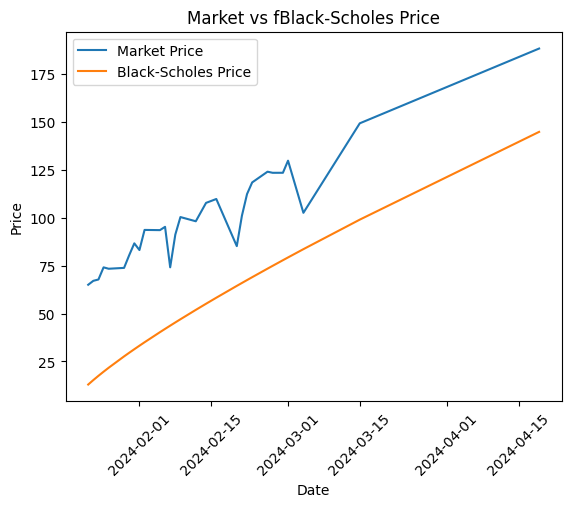

In [111]:
future_options = pd.read_csv('weekly_contracts_100.csv')

K = 4775.0

temp_df = future_options[future_options.Strike == K]\
    [['Maturity', 'Close']]
temp_df['Maturity'] = pd.to_datetime(temp_df['Maturity'])

temp_df = temp_df[temp_df['Maturity'] < '2024-05-01']

temp_df.sort_values(by='Maturity', inplace=True)

s0 = spx.iloc[-1].item()
r = irx.iloc[-1].item()*0.01

T = lambda x: (x - pd.to_datetime(maturity_date)).days / 365

temp_df['fBS']  = temp_df["Maturity"].apply(
        lambda x: fBS_call_price(s0, K, T(x), 0, r, sigma, H)
    )

plt.plot(temp_df['Maturity'], temp_df['Close'], label='Market Price')
plt.plot(temp_df['Maturity'], temp_df['fBS'], label='Black-Scholes Price')
plt.tick_params(axis='x', rotation=45)

plt.legend(['Market Price', 'Black-Scholes Price'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Market vs fBlack-Scholes Price")

plt.show()

In [112]:
print("Least Squares Error: ", ((temp_df['fBS'] - temp_df['Close'])**2).mean())

Least Squares Error:  2301.523972786682


In [113]:
spx_on_maturity = yf.download("^SPX", start='2024-01-01', end='2024-12-31')['Close']
spx_on_maturity = spx_on_maturity[spx_on_maturity.index.isin(temp_df['Maturity'])]


temp_df['SPX'] = temp_df['Maturity'].map(spx_on_maturity.to_dict()['^SPX'])

temp_df["Payoff"] = temp_df.apply(lambda x: x['SPX'] - K, axis=1)
temp_df["Payoff Ratio"] = temp_df["Payoff"] / temp_df["Close"]

[*********************100%***********************]  1 of 1 completed


In [114]:
np.corrcoef(
    np.abs(temp_df['Close']-temp_df['fBS']), 
    temp_df['Payoff Ratio']
)

array([[ 1.        , -0.51590853],
       [-0.51590853,  1.        ]])

### **DFA** method for Hurst Exponent estimate

[*********************100%***********************]  1 of 1 completed

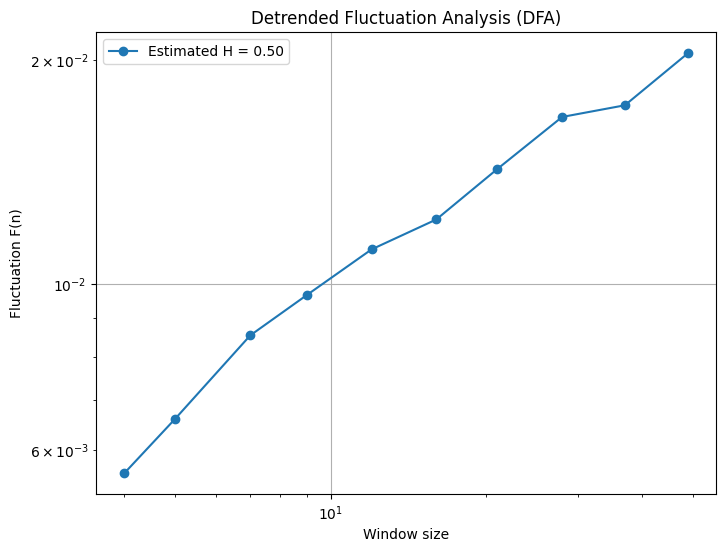

Estimated Hurst exponent: 0.4992


In [88]:
import numpy as np
import matplotlib.pyplot as plt

last_date =  historical.index[-1]

spx_cal = yf.download("^SPX", 
        start=pd.to_datetime(last_date) - pd.DateOffset(years=2), 
        end=next_date
    )['Close']

spx_cal = np.log(spx_cal/spx_cal.shift(1)).dropna().values.flatten()

def compute_dfa(time_series, min_window=4, max_window=None, num_windows=10):
    """
    Compute the Hurst exponent using Detrended Fluctuation Analysis (DFA).
    
    Parameters:
    - time_series (np.array): The input time series data.
    - min_window (int): The smallest segment size (window length).
    - max_window (int): The largest segment size. Defaults to len(time_series) / 4.
    - num_windows (int): The number of windows (log-spaced).

    Returns:
    - hurst_exponent (float): Estimated Hurst exponent.
    - window_sizes (np.array): The different segment sizes used.
    - fluctuations (np.array): The fluctuation function values.
    """
    
    N = len(time_series)
    if max_window is None:
        max_window = N // 10  # Default maximum window size
    
    # Convert time series to profile (cumulative sum of mean-adjusted series)
    mean_adjusted_series = time_series - np.mean(time_series)
    profile = np.cumsum(mean_adjusted_series)

    # Logarithmically spaced window sizes
    window_sizes = np.unique(np.logspace(np.log10(min_window), np.log10(max_window), num=num_windows, dtype=int))

    fluctuations = []
    
    for window in window_sizes:
        n_segments = N // window
        residuals = []

        for i in range(n_segments):
            segment_start = i * window
            segment_end = (i + 1) * window
            segment = profile[segment_start:segment_end]

            x = np.arange(window)
            p = np.polyfit(x, segment, 1)  # Linear detrending
            trend = np.polyval(p, x)

            residuals.append(np.mean((segment - trend) ** 2))
    
        F_n = np.sqrt(np.mean(residuals))
        fluctuations.append(F_n)
        
    log_window_sizes = np.log(window_sizes)
    log_fluctuations = np.log(fluctuations)
    slope, intercept = np.polyfit(log_window_sizes, log_fluctuations, 1)
    hurst_exponent = slope

    return hurst_exponent, window_sizes, fluctuations

np.random.seed(42)
N = 5000
random_series = np.cumsum(np.random.randn(N))
hurst, window_sizes, fluctuations = compute_dfa(spx)


plt.figure(figsize=(8, 6))
plt.loglog(window_sizes, fluctuations, 'o-', label=f'Estimated H = {hurst:.2f}')
plt.xlabel("Window size")
plt.ylabel("Fluctuation F(n)")
plt.title("Detrended Fluctuation Analysis (DFA)")
plt.legend()
plt.grid()
plt.show()

print(f"Estimated Hurst exponent: {hurst:.4f}")


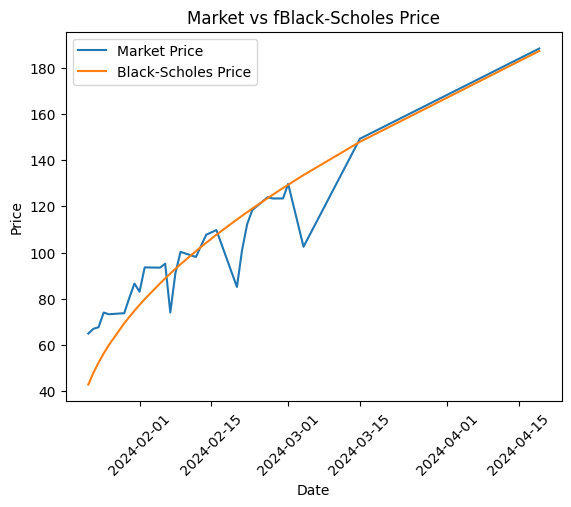

In [ ]:
sigma_dfa = 0.1391
H_dfa = 0.75


future_options = pd.read_csv('weekly_contracts_100.csv')

K = 4775.0

temp_df = future_options[future_options.Strike == K]\
    [['Maturity', 'Close']]
temp_df['Maturity'] = pd.to_datetime(temp_df['Maturity'])

temp_df = temp_df[temp_df['Maturity'] < '2024-05-01']

temp_df.sort_values(by='Maturity', inplace=True)

s0 = spx.iloc[-1].item()
r = irx.iloc[-1].item()*0.01

T = lambda x: (x - pd.to_datetime(maturity_date)).days / 365

temp_df['fBS']  = temp_df["Maturity"].apply(
        lambda x: fBS_call_price(s0, K, T(x), 0, r, sigma_dfa, H_dfa)
    )

plt.plot(temp_df['Maturity'], temp_df['Close'], label='Market Price')
plt.plot(temp_df['Maturity'], temp_df['fBS'], label='Black-Scholes Price')
plt.tick_params(axis='x', rotation=45)

plt.legend(['Market Price', 'Black-Scholes Price'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Market vs fBlack-Scholes Price")

plt.show()

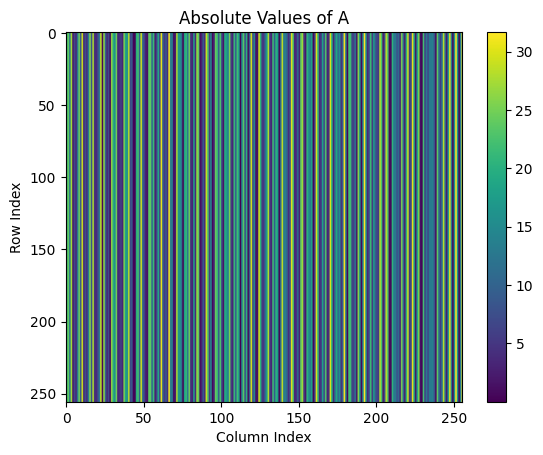

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



def g(t):
    sigma = 0.025
    return 1 / (sigma * np.sqrt(2 * np.pi)) \
        * np.exp(-(t**2 / (2 * sigma**2)))



# def fft_comp(xi):
#     return np.sum(
#         np.fromiter(
#             (g(t[i])*np.exp(-2j*np.pi*xi*i/N) for i in range(N))
#         , dtype=np.complex128)
#     )


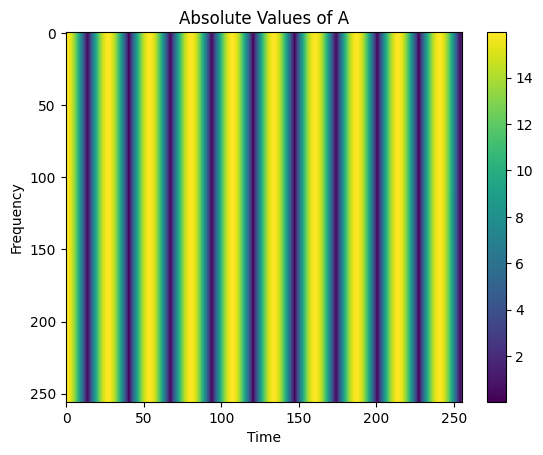

In [5]:
import numpy as np 
import matplotlib.pyplot as plt


# def x(t): return np.cos(2 * np.pi * (2 * t + \
#         0.2 * np.cos(t))) + np.cos(2 * np.pi * \
#         (3 * t + 0.02 * t**2))

def x(t): return np.cos(t)

def g(t):return 1 / (sigma * np.sqrt(2 * np.pi)) \
        * np.exp(-(t**2 / (2 * sigma**2)))

def shift(x, n): return np.concatenate((x[-n:], x[:-n]))


N = 256
t = np.linspace(0, 30, N)
sigma = 0.025

A = np.zeros((N, N), dtype=np.complex128)

xt = x(t)

for i in range(N):
    A[:, i] = np.fft.fft(xt * g(t - t[i]))

plt.imshow(np.abs(A), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Absolute Values of A')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

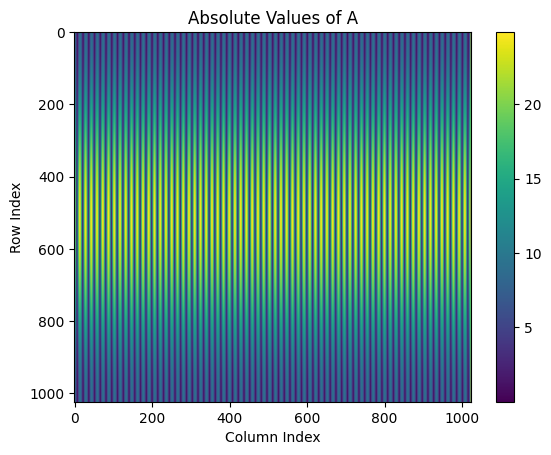

In [8]:

def shift(x, n):
    return np.concatenate((x[-n:], x[:-n]))

def x(t): return np.cos(100*np.pi*t)

N = 1024
t = np.linspace(0, 30, N)

fx = np.fft.fft(x(t))

A = np.zeros((N, N), dtype=np.complex128)

for i in range(N):
    A[i, :] = np.fft.ifft(fx * shift(np.fft.fft(g(t))[::-1], i+1))


plt.imshow(np.abs(A), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Absolute Values of A')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

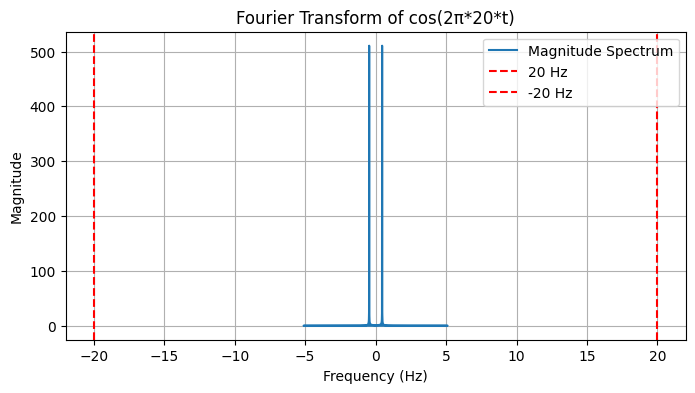

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def x(t):
    return np.cos(2 * np.pi * 20 * t)

# Define number of samples and time array
N = 1024
t = np.linspace(0, 100, N)
dt = t[1] - t[0]  # time step

# Compute the Fourier transform and shift zero frequency component to center
X = np.fft.fft(x(t))
X_shifted = np.fft.fftshift(X)

# Create the frequency axis
freq = np.fft.fftfreq(N, dt)
freq_shifted = np.fft.fftshift(freq)

# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(freq, np.abs(X), label='Magnitude Spectrum')

plt.axvline(x=20, color='r', linestyle='--', label='20 Hz')
plt.axvline(x=-20, color='r', linestyle='--', label='-20 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform of cos(2π*20*t)')
plt.legend()
plt.grid(True)
plt.show()


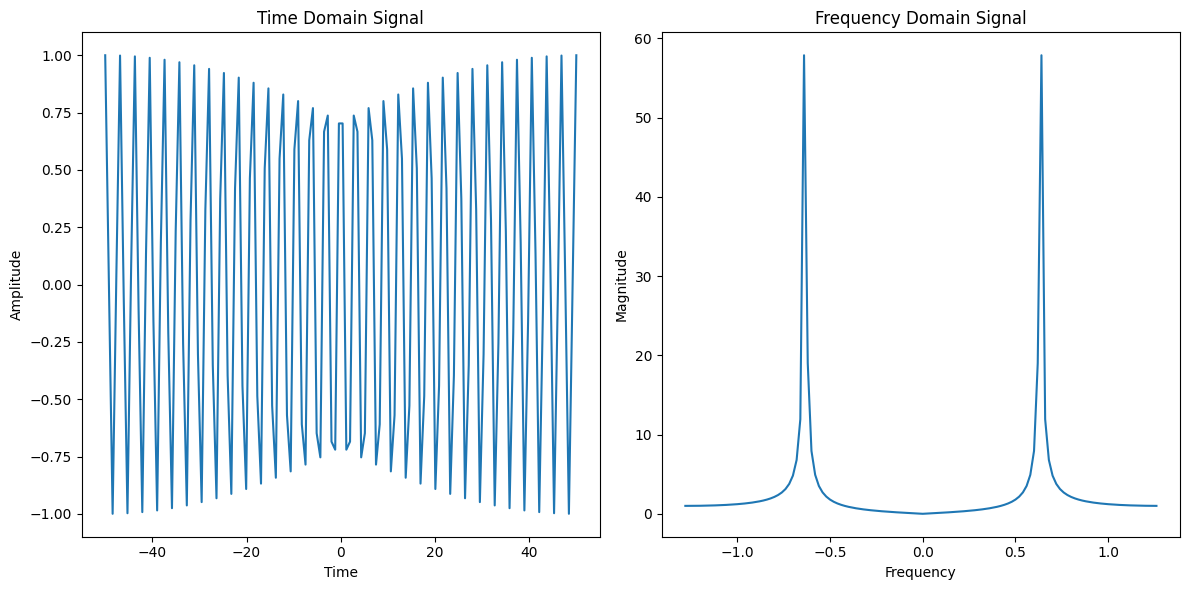

In [118]:
omega = 20
def x(t): return np.cos(2 * np.pi * omega * t)

T = 50
N = 128

t = np.linspace(-T, T, N)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t, x(t))
plt.title("Time Domain Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)

plt.plot(
    np.fft.fftshift(np.fft.fftfreq(N, T/N)),
    np.abs(np.fft.fft(x(t)))
)

# plt.axvline(x=20*50/128, color='r', linestyle='--', label='x=2')

plt.title("Frequency Domain Signal")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()


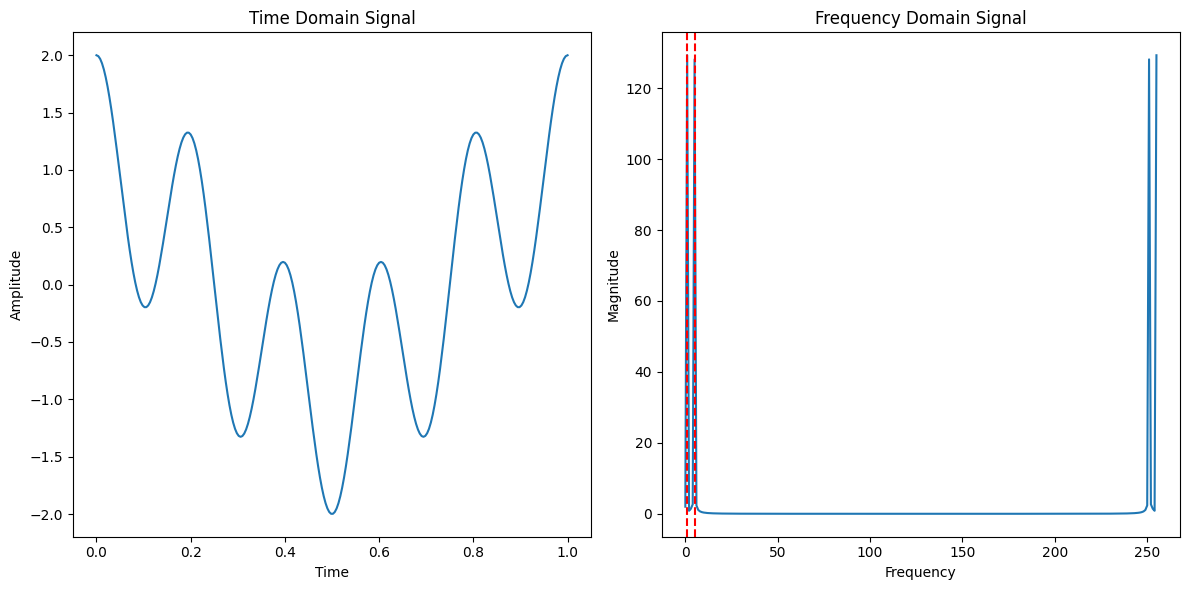

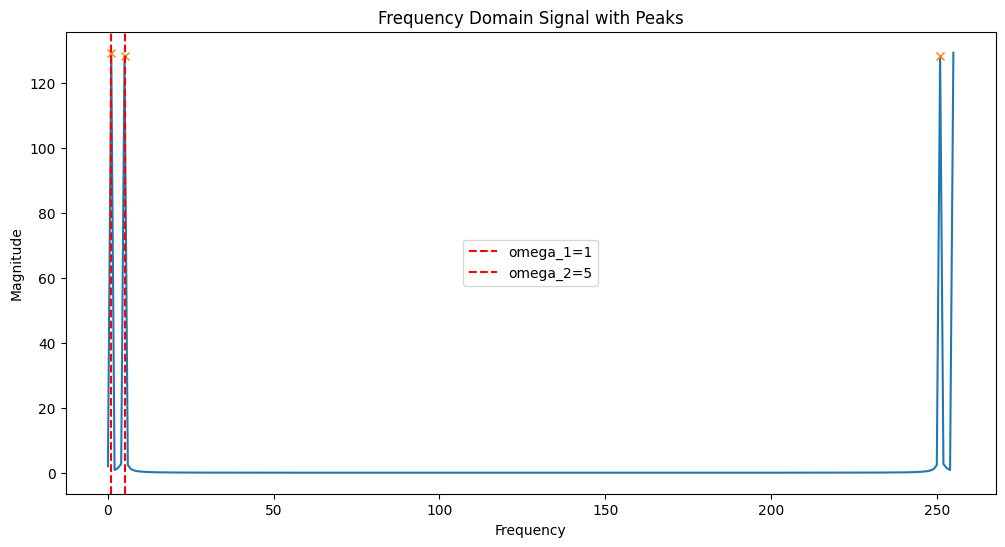

In [ ]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

omega_1 = 1
omega_2 = 5
def x(t): return np.cos(2 * np.pi * omega_1 * t) + np.cos(2 * np.pi * omega_2 * t) 

T = 1
N = int(256*T)

t = np.linspace(0, T, N)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t, x(t))
plt.title("Time Domain Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)

# Compute the FFT and its magnitude
fft_values = np.abs(np.fft.fft(x(t)))

plt.plot(
    fft_values
)

plt.axvline(x=omega_1, color='r', linestyle='--', label='x=2')
plt.axvline(x=omega_2, color='r', linestyle='--', label='x=2')

plt.title("Frequency Domain Signal")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()


# Find peaks in the FFT magnitude
peaks, _ = find_peaks(fft_values, height=0)

# Plot the peaks on the frequency domain graph
plt.figure(figsize=(12, 6))
plt.plot(fft_values)
plt.plot(peaks, fft_values[peaks], "x")
plt.axvline(x=omega_1, color='r', linestyle='--', label=f'omega_1={omega_1}')
plt.axvline(x=omega_2, color='r', linestyle='--', label=f'omega_2={omega_2}')
plt.title("Frequency Domain Signal with Peaks")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.legend()
plt.show()